### likelihood

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (11, 5)  #set default figure size
import numpy as np
from numpy import exp
from scipy.special import factorial
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D
import statsmodels.api as sm
from statsmodels.api import Poisson
from scipy import stats
from scipy.stats import norm
from statsmodels.iolib.summary2 import summary_col

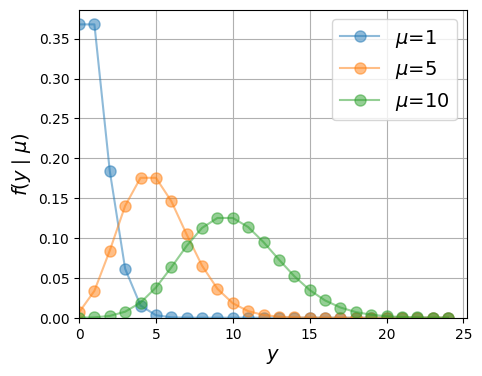

In [2]:
# определяем функцию плотности
poisson_pmf = lambda y, μ: μ**y / factorial(y) * exp(-μ)

# набор данных
y_values = range(0, 25)

fig, ax = plt.subplots(figsize=(5, 4))

# пробуем различные параметры μ
for μ in [1, 5, 10]:
    distribution = []
    for y_i in y_values:
        result = poisson_pmf(y_i, μ)
        distribution.append(result)
    
    ax.plot(
        y_values,
        distribution,
        label=f'$\mu$={μ}',
        alpha=0.5,
        marker='o',
        markersize=8
    )

ax.grid()
ax.set_xlabel('$y$', fontsize=14)
ax.set_ylabel('$f(y \mid \mu)$', fontsize=14)
ax.axis(xmin=0, ymin=0)
ax.legend(fontsize=14)

plt.show()

In [5]:
pd.options.display.max_columns = 10

# Load in data and view
df = pd.read_stata('../../data/fp.dta')
df.head()

,country,ccode,year,cyear,numbil,...,topint08,rintr,noyrs,roflaw,nrrents
0,United States,2.0,1990.0,21990.0,NaN,...,39.799999,4.988405,20.0,1.61,NaN
1,United States,2.0,1991.0,21991.0,NaN,...,39.799999,4.988405,20.0,1.61,NaN
2,United States,2.0,1992.0,21992.0,NaN,...,39.799999,4.988405,20.0,1.61,NaN
3,United States,2.0,1993.0,21993.0,NaN,...,39.799999,4.988405,20.0,1.61,NaN
4,United States,2.0,1994.0,21994.0,NaN,...,39.799999,4.988405,20.0,1.61,NaN


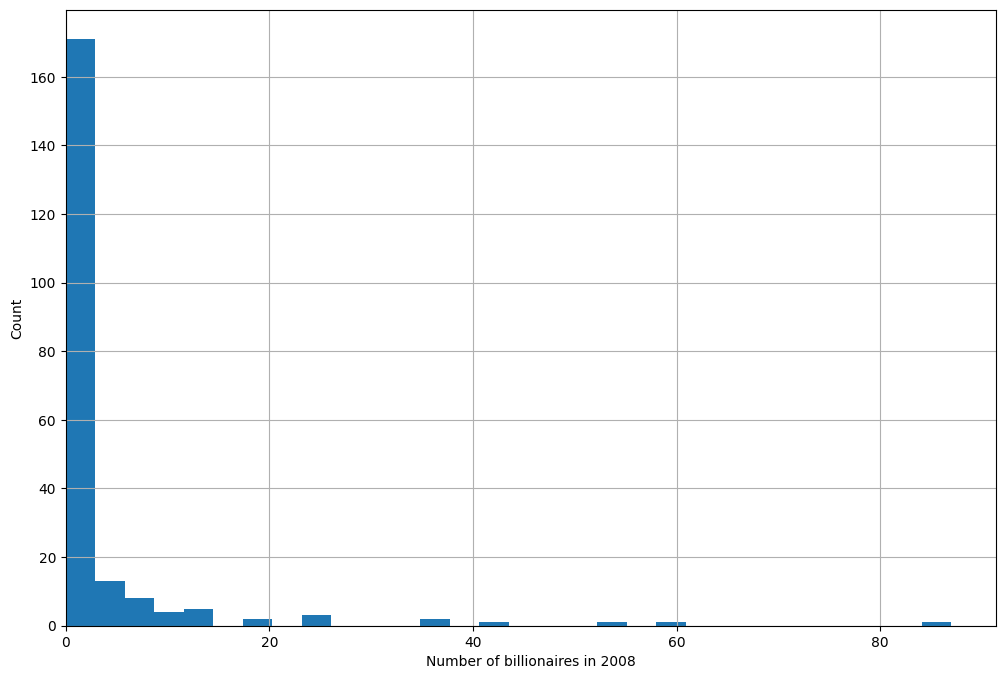

In [6]:
numbil0_2008 = df[(df['year'] == 2008) & (
    df['country'] != 'United States')].loc[:, 'numbil0']

plt.subplots(figsize=(12, 8))
plt.hist(numbil0_2008, bins=30)
plt.xlim(left=0)
plt.grid()
plt.xlabel('Number of billionaires in 2008')
plt.ylabel('Count')
plt.show()

глядя на график можно понять что мы имеем дело с пуасоновским распределением, с маленьким параметром μ

In [7]:
a = np.array([1, 2, 3])
b = np.array([1, 2, 3])
print(a@b)
print(a.dot(b))

14
14


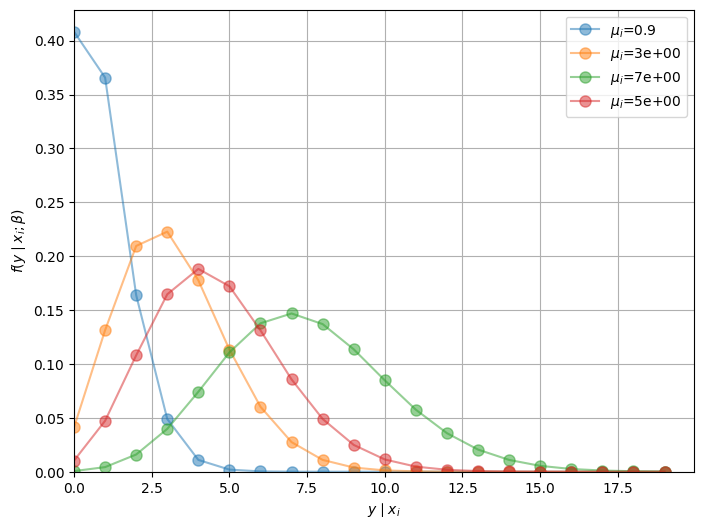

In [8]:
y_values = range(0, 20)

# это набор наших параметров, в данном случае у нас их всего 5
β = np.array([0.26, 0.18, 0.25, -0.1, -0.22])

# это вектор с нашими данными, наблюдениями. 
# это может быть условная строчка из датасета выше
datasets = [
    np.array([0, 1, 1, 1, 2]),
	np.array([2, 3, 2, 4, 0]),
	np.array([3, 4, 5, 3, 2]),
	np.array([6, 5, 4, 4, 7])
]


fig, ax = plt.subplots(figsize=(8, 6))

for X in datasets:
    # через матричное произведение мы обуславливаемся на данные
    # и тем самым меняем конечно распределение данных
    μ = exp(X @ β)
    distribution = []
    for y_i in y_values:
        distribution.append(poisson_pmf(y_i, μ))
    
    ax.plot(
        y_values,
		distribution,
		label=f'$\mu_i$={μ:.1}',
		marker='o',
		markersize=8,
		alpha=0.5
	)

ax.grid()
ax.legend()
ax.set_xlabel('$y \mid x_i$')
ax.set_ylabel(r'$f(y \mid x_i; \beta )$')
ax.axis(xmin=0, ymin=0)
plt.show()

данная иллюстрация показывает как данные влияют на конечное распределение

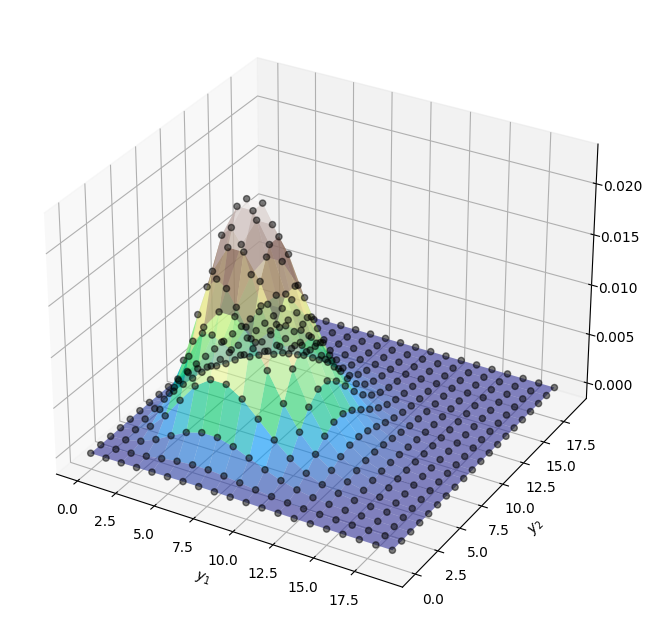

In [9]:
def plot_joint_poisson(
		# предположим что наше распределение имеет параметр 7
    μ=7, 
		y_n=20
    ):
    # задаем сетку 
    yi_values = np.arange(0, y_n, 1)

    # задаем 2д сетку
    X, Y = np.meshgrid(yi_values, yi_values)

    # перемножаем получившиеся распределения между собой
    # тем самым получая joint distribution
    Z = poisson_pmf(X, μ) * poisson_pmf(Y, μ)

    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection='3d')
    # рисуем поверхность по получившимся точкам в пространстве
    ax.plot_surface(X, Y, Z.T, cmap='terrain', alpha=0.6)
    ax.scatter(X, Y, Z.T, color='black', alpha=0.5, linewidths=1)
    ax.set(xlabel='$y_1$', ylabel='$y_2$')
    ax.set_zlabel('$f(y_1, y_2)$', labelpad=10)
    plt.show()

plot_joint_poisson(μ=7, y_n=20)

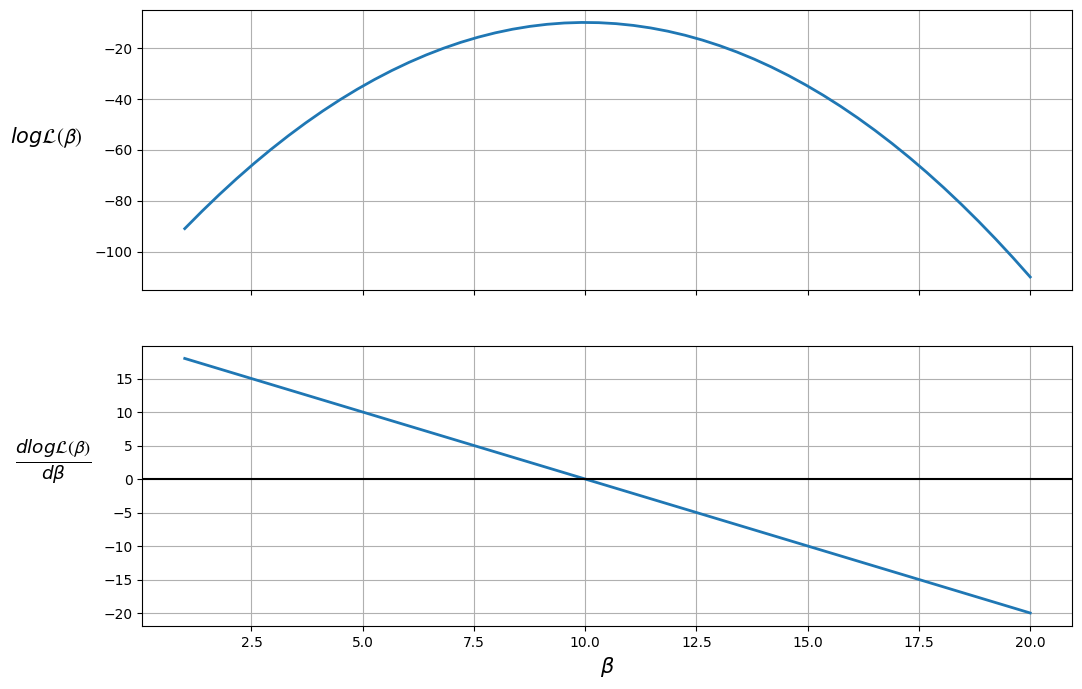

In [10]:
β = np.linspace(1, 20)
# рандомная функция взятая в качестве примера
# чтобы показать общую идею метода
logL = -(β - 10) ** 2 - 10
dlogL = -2 * β + 20

fig, (ax1, ax2) = plt.subplots(2, sharex=True, figsize=(12, 8))

ax1.plot(β, logL, lw=2)
ax2.plot(β, dlogL, lw=2)

ax1.set_ylabel(
    r'$log \mathcal{L(\beta)}$',
	rotation=0,
	labelpad=35,
	fontsize=15
)
ax2.set_ylabel(
    r'$\frac{dlog \mathcal{L(\beta)}}{d \beta}$ ',
	rotation=0,
	labelpad=35,
	fontsize=19
)

ax2.set_xlabel(r'$\beta$', fontsize=15)
ax1.grid(), ax2.grid()
plt.axhline(c='black')
plt.show()

при помощи первой производной мы можем посмотреть где функция меняет свой знак, а соответственно посмотреть на точки экстремума.
это может нам дать представление где лежит ее минимум чтобы минимизировать log likelihood

в нашем случае при 10 likelihood достигает максимума 

для автоматического нахождения корня мы будем использовать Newton-Raphson algorithm

In [13]:
class PoissonRegression:

    def __init__(self, y, X, β):
        self.X = X
        self.n, self.k = X.shape
        # Reshape y as a n_by_1 column vector
        self.y = y.reshape(self.n, 1)
        # Reshape β as a k_by_1 column vector
        self.β = β.reshape(self.k, 1)

    def μ(self):
        return np.exp(self.X.dot(self.β))

    def logL(self):
        # прологарифмированная функция распределения пуасонна
        y = self.y
        μ = self.μ()
        return np.sum(y * np.log(μ) - μ - np.log(factorial(y)))

    def G(self):
        # первая производная от функции правдоподобия
        # не понятно почему не взята общая формула взятая производной
        # через разницу f(x+d_x) - f(x) / (d_x - x )
        # d_x - х измененный на супермаленькое число
        
        y = self.y
        μ = self.μ()
        return X.T.dot((y - μ))

    def H(self):
        # вторая производная от функции правдоподобия
        # еще называется Hessian matrice
        X = self.X
        μ = self.μ()
        return -(X.T.dot((μ * X)))

реализация алгоритма newton raphson

![](./Screenshot%202023-01-03%20220355.png)

это реализация алгоритма обновления, но в матричном виде

In [15]:
def newton_raphson(
    model, 
    tollerance=1e-3,
    max_iterations=1000,
    display=True
):

    i = 0
    error = 100  # Initial error value

    # Print header of output
    if display:
        header = f'{"Iteration_k":<13}{"Log-likelihood":<16}{"θ":<60}'
        print(header)
        print("-" * len(header))

    # пока наши параметры меняются сильнее чем tollerance
    # или мы не достигли максимальнео количество итераций
    # то продложаем обучение  
    while np.any(error > tollerance) and i < max_iterations:
        # получаем матрицы с первым и второй производной
        H, G = model.H(), model.G()
        # матричная форма обновления параметров
        β_new = model.β - (np.linalg.inv(H).dot(G))
        error = β_new - model.β
        # сохраняем полученный результат в модель
        model.β = β_new

        # Print iterations
        if display:
            β_list = [f'{t:.3}' for t in list(model.β.flatten())]
            log_likelihood = model.logL()
            update = f'{i:<13}{log_likelihood:<16.8}{β_list}'
            print(update)

        i += 1

    print(f'Number of iterations: {i}')
    print(f'β_hat = {model.β.flatten()}')

    # Return a flat array for β (instead of a k_by_1 column vector)
    return model.β.flatten()

X = np.array([[1, 2, 5],
              [1, 1, 3],
              [1, 4, 2],
              [1, 5, 2],
              [1, 3, 1]])

y = np.array([1, 0, 1, 1, 0])

# Take a guess at initial βs
init_β = np.array([0.1, 0.1, 0.1])

# Create an object with Poisson model values
poi = PoissonRegression(y, X, β=init_β)

# Use newton_raphson to find the MLE
β_hat = newton_raphson(poi, display=True)

Iteration_k  Log-likelihood  θ                                                           
-----------------------------------------------------------------------------------------
0            -4.3447622      ['-1.49', '0.265', '0.244']
1            -3.5742413      ['-3.38', '0.528', '0.474']
2            -3.3999526      ['-5.06', '0.782', '0.702']
3            -3.3788646      ['-5.92', '0.909', '0.82']
4            -3.3783559      ['-6.07', '0.933', '0.843']
5            -3.3783555      ['-6.08', '0.933', '0.843']
Number of iterations: 6
β_hat = [-6.07848205  0.93340226  0.84329625]


по мере того как алгоритм сходится, в идеальных условиях, log likelihood должен уменьшаться, что и происходит

ниже приведена визуализация работы данного алгоритма

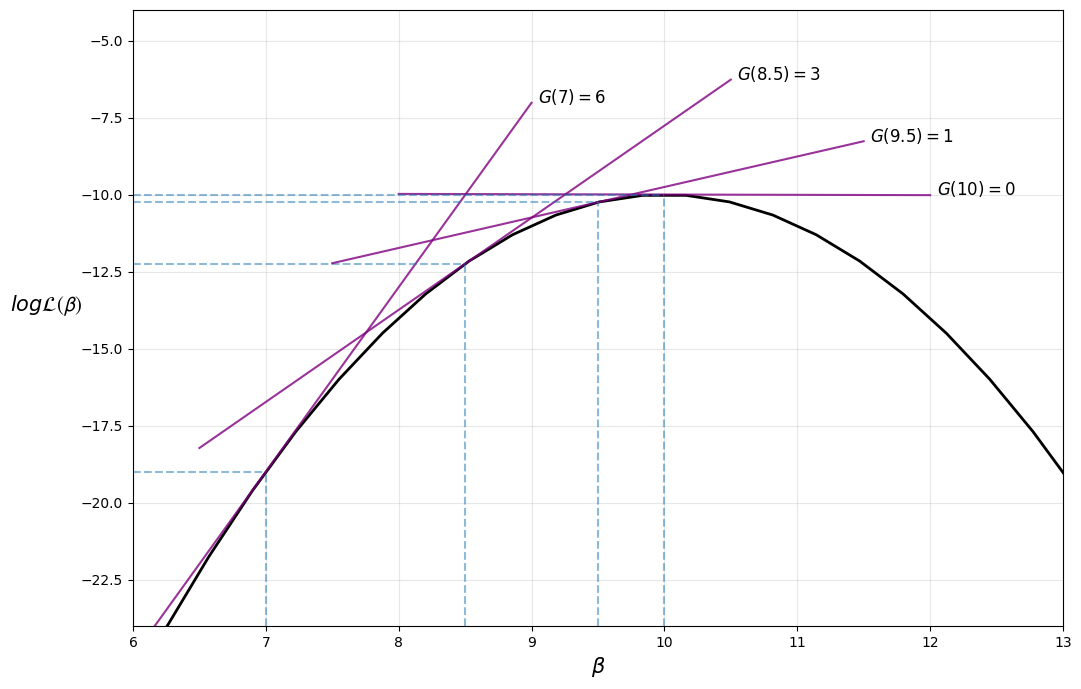

In [16]:
logL = lambda x: -(x - 10) ** 2 - 10

def find_tangent(β, a=0.01):
    y1 = logL(β)
    y2 = logL(β+a)
    x = np.array([[β, 1], [β+a, 1]])
    m, c = np.linalg.lstsq(x, np.array([y1, y2]), rcond=None)[0]
    return m, c

β = np.linspace(2, 18)
fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(β, logL(β), lw=2, c='black')

for β in [7, 8.5, 9.5, 10]:
    β_line = np.linspace(β-2, β+2)
    m, c = find_tangent(β)
    y = m * β_line + c
    ax.plot(β_line, y, '-', c='purple', alpha=0.8)
    ax.text(β+2.05, y[-1], f'$G({β}) = {abs(m):.0f}$', fontsize=12)
    ax.vlines(β, -24, logL(β), linestyles='--', alpha=0.5)
    ax.hlines(logL(β), 6, β, linestyles='--', alpha=0.5)

ax.set(ylim=(-24, -4), xlim=(6, 13))
ax.set_xlabel(r'$\beta$', fontsize=15)
ax.set_ylabel(
    r'$log \mathcal{L(\beta)}$',
	rotation=0,
    labelpad=25,
	fontsize=15
)
ax.grid(alpha=0.3)
plt.show()

## тоже самое, но с импользованием пакета statsmodels

In [18]:
X = np.array([
    [1, 2, 5],
	[1, 1, 3],
	[1, 4, 2],
	[1, 5, 2],
	[1, 3, 1]
])

y = np.array([1, 0, 1, 1, 0])

stats_poisson = Poisson(y, X).fit()
print(stats_poisson.summary())

Optimization terminated successfully.
         Current function value: 0.675671
         Iterations 7
                          Poisson Regression Results                          
Dep. Variable:                      y   No. Observations:                    5
Model:                        Poisson   Df Residuals:                        2
Method:                           MLE   Df Model:                            2
Date:                Tue, 03 Jan 2023   Pseudo R-squ.:                  0.2546
Time:                        22:22:46   Log-Likelihood:                -3.3784
converged:                       True   LL-Null:                       -4.5325
Covariance Type:            nonrobust   LLR p-value:                    0.3153
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -6.0785      5.279     -1.151      0.250     -16.425       4.268
x1             0.9334      0.

видно что наш метод, написанный выше сходится к такому же значению

In [21]:
# Keep only year 2008
df = df[df['year'] == 2008]

# Add a constant
df['const'] = 1

# Variable sets
reg1 = ['const', 'lngdppc', 'lnpop', 'gattwto08']
reg2 = ['const', 'lngdppc', 'lnpop',
        'gattwto08', 'lnmcap08', 'rintr', 'topint08']
reg3 = ['const', 'lngdppc', 'lnpop', 'gattwto08', 'lnmcap08',
        'rintr', 'topint08', 'nrrents', 'roflaw']

# Specify model
poisson_reg = sm.Poisson(
    df[['numbil0']], 
    df[reg1],
	missing='drop').fit(cov_type='HC0')

print(poisson_reg.summary())

Optimization terminated successfully.
         Current function value: 2.226090
         Iterations 9
                          Poisson Regression Results                          
Dep. Variable:                numbil0   No. Observations:                  197
Model:                        Poisson   Df Residuals:                      193
Method:                           MLE   Df Model:                            3
Date:                Tue, 03 Jan 2023   Pseudo R-squ.:                  0.8574
Time:                        22:29:16   Log-Likelihood:                -438.54
converged:                       True   LL-Null:                       -3074.7
Covariance Type:                  HC0   LLR p-value:                     0.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        -29.0495      2.578    -11.268      0.000     -34.103     -23.997
lngdppc        1.0839      0.

In [22]:
regs = [reg1, reg2, reg3]
reg_names = ['Model 1', 'Model 2', 'Model 3']
info_dict = {
    'Pseudo R-squared': lambda x: f"{x.prsquared:.2f}",
	'No. observations': lambda x: f"{int(x.nobs):d}"
}
regressor_order = [
    'const',
	'lngdppc',
	'lnpop',
	'gattwto08',
	'lnmcap08',
	'rintr',
	'topint08',
	'nrrents',
	'roflaw'
]
results = []

for reg in regs:
    model = sm.Poisson(
        df[['numbil0']], 
        df[reg],
		missing='drop'
  	)
    
    result = model.fit(
        cov_type='HC0',
		maxiter=100, 
  		disp=0
    )
    results.append(result)

results_table = summary_col(
    results=results,
	float_format='%0.3f',
	stars=True,
	model_names=reg_names,
	info_dict=info_dict,
	regressor_order=regressor_order
)

results_table.add_title('Table 1 - Explaining the Number of Billionaires in 2008')
print(results_table)

Table 1 - Explaining the Number of Billionaires in 2008
                  Model 1    Model 2    Model 3  
-------------------------------------------------
const            -29.050*** -19.444*** -20.858***
                 (2.578)    (4.820)    (4.255)   
lngdppc          1.084***   0.717***   0.737***  
                 (0.138)    (0.244)    (0.233)   
lnpop            1.171***   0.806***   0.929***  
                 (0.097)    (0.213)    (0.195)   
gattwto08        0.006      0.007      0.004     
                 (0.007)    (0.006)    (0.006)   
lnmcap08                    0.399**    0.286*    
                            (0.172)    (0.167)   
rintr                       -0.010     -0.009    
                            (0.010)    (0.010)   
topint08                    -0.051***  -0.058*** 
                            (0.011)    (0.012)   
nrrents                                -0.005    
                                       (0.010)   
roflaw                                 0.203

123 

In [1]:
1

1